# Data Casal Montserratina

In [107]:
#Data Manipulation
import pandas as pd
import numpy as np

# Plots
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly
import plotly.express as px

#Others
import os
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose

#Parameters Dict
parameters = {
    "paths": {
        "2022_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202201_202206.csv",
        "2022_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202207_202212.csv",
        "2023_01_06": "../data/data_casal_montserratina/Casal_Montserratina_202301_202306.csv",
        "2023_07_12": "../data/data_casal_montserratina/Casal_Montserratina_202307_202312.csv",
        "2024_01_05": "../data/data_casal_montserratina/Casal_Montserratina_202401_202405.csv",
    }
}

# Funciones

In [108]:
# TODO cambiar la funcion para que le pase solo el DF. que tome la fecha como parametro por defecto y le paso el valor de Y
import plotly.graph_objects as go
import plotly.io as pio

# # Asegúrate de tener kaleido instalado: pip install -U kaleido
# # Establece kaleido como el motor para escribir imágenes
# pio.kaleido.scope.default_format = "png"  # Opcional: puede ser "png", "jpeg", etc.
# pio.kaleido.scope.default_width = 800  # Opcional: ancho predeterminado de la imagen
# pio.kaleido.scope.default_height = 600  # Opcional: altura predeterminada de la imagen

def grafico_zoom(df_x, df_y, title="", yaxis_title=""):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_x, 
        y=df_y, 
        mode='lines', 
        name='Line', 
        connectgaps=False 
    ))
    fig.update_layout(
        title=title,  
        xaxis_title="Date",
        yaxis_title=yaxis_title, 
        xaxis_tickangle=0, 
        showlegend=False
    )
    
    # # Guardar la imagen en el archivo especificado
    # fig.write_image(file, format="png")
    
    fig.show()


In [109]:
#Prints the NaN Values per Column of a dataset
def checkNaNValues(df):
    return print(f"NaN Count per Column", df.isna().any(axis=1).sum())

In [110]:
#Checks if there is any missing time series
def checkMissingData(df, date_column):
    min_date = df[date_column].min()
    max_date = df[date_column].max()

    date_range = pd.date_range(start=min_date, end=max_date, freq='h')
    missing_dates = date_range[~date_range.isin(df[date_column])]
    print(f"Number of Missing Values: {missing_dates.shape[0]}")
    return None if missing_dates.shape[0] == 0 else missing_dates, date_range

In [111]:
def getNumberOfOutliersPerColumn(df, columns_list):
    for col in columns_list:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        #Calcular los límites inferiores y superiores para identificar outliers
        lim_inf = q1 - (1.5 * iqr)
        lim_sup = q3 + (1.5 * iqr)

        outliers = ((df[col] < lim_inf) | (df[col] > lim_sup))
        print(f"For {col} Column, the Number of Outliers is {outliers.sum()}. Sus limites son {lim_inf} y {lim_sup}.\n")

In [112]:
def dataframe_slicer (df, fecha_inicial, fecha_final):
    """
    Recorta el DataFrame en base a una fecha inicial y otra final.

    Parameters:
    df (DataFrame): El DataFrame original que contiene los datos.
    fecha_inicial (str): La fecha inicial en formato 'YYYY-MM-DD HH:MM:SS'.
    fecha_final (str): La fecha final en formato 'YYYY-MM-DD HH:MM:SS'.

    Returns:
    DataFrame: Un nuevo DataFrame recortado.
    """
    # Convertir las columnas de fecha a datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Filtrar el DataFrame en base a las fechas
    df_recortado = df[(df['Date'] >= fecha_inicial) & (df['Date'] <= fecha_final)]
    
    return df_recortado

# Load Data

In [113]:
ruta_data = "../data/data_casal_montserratina/"

In [114]:
df1 = pd.read_csv(parameters["paths"]["2022_01_06"], delimiter=";")
df2 = pd.read_csv(parameters["paths"]["2022_07_12"], delimiter=";")
df3 = pd.read_csv(parameters["paths"]["2023_01_06"], delimiter=";")
df4 = pd.read_csv(parameters["paths"]["2023_07_12"], delimiter=";")
df5 = pd.read_csv(parameters["paths"]["2024_01_05"], delimiter=";")

In [115]:
# hago un concat de los 4 datasets, para Unir los DataFrames uno a continuación del otro
df = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
df.head()

TimeStamp  Valor  Període tarifari Tipus lectura
0  01/01/2022 00:00      6                 6          Real
1  01/01/2022 01:00      6                 6          Real
2  01/01/2022 02:00      5                 6          Real
3  01/01/2022 03:00      7                 6          Real
4  01/01/2022 04:00      7                 6          Real

In [116]:
df["TimeStamp"] = pd.to_datetime(df["TimeStamp"], format="%d/%m/%Y %H:%M")
df = df.drop(columns=["Tipus lectura", "Període tarifari"])
df.rename(columns={'TimeStamp': 'Date', 
                   'Valor': 'Consumo'}, inplace=True)

# Missing values

In [117]:
checkNaNValues(df)
missing_dates, date_range = checkMissingData(df, 'Date')

NaN Count per Column 0
Number of Missing Values: 2906


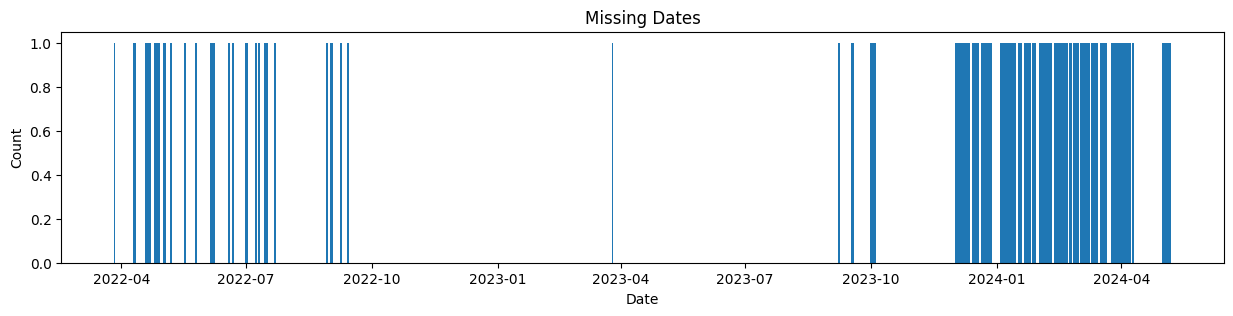

In [118]:
plt.figure(figsize=(15, 3))
plt.bar(missing_dates, [1] * len(missing_dates))
plt.title("Missing Dates")
plt.xlabel("Date")
plt.ylabel("Count")

plt.savefig("missing_dates.png", bbox_inches='tight')
plt.show()

Un ejemplo de fechas faltantes; notar que entre las 01:00 y las 03:00 no hay datos. 

In [119]:
print(df[(df["Date"]>="2022-03-27 00:00:00") & (df["Date"]<"2022-03-27 05:00:00")])

                    Date  Consumo
2040 2022-03-27 00:00:00        2
2041 2022-03-27 01:00:00        3
2042 2022-03-27 03:00:00        2
2043 2022-03-27 04:00:00        2


### rellenar los huecos de Date

Antes de mostrar la gráfica del timeseries, hay que rellenar los huecos que haya en la columna de fechas, sinó las herramientas para graficar hacer interpolación de los datos faltantes, en definitiva, no se perciben los huecos. 

In [120]:
df = df.drop_duplicates(keep=False) # duplicados no hay, pero surgió un par de veces ese error al hacer el reindex. 

df.set_index("Date", inplace=True)

# Reindexa el DataFrame con el nuevo rango de fechas y rellena los valores faltantes con NaN
data_reindexed = df.reindex(date_range)

data_reindexed.reset_index(inplace=True)
data_reindexed.rename(columns={'index': 'Date'}, inplace=True) 

Ya no hay huecos en la columna Date, ahora aparecen rellenas!... con Nulls, tiny bam! 

In [121]:
print(data_reindexed[(data_reindexed["Date"]>="2022-03-27 00:00:00") & (data_reindexed["Date"]<"2022-03-27 05:00:00")])

                    Date  Consumo
2040 2022-03-27 00:00:00      2.0
2041 2022-03-27 01:00:00      3.0
2042 2022-03-27 02:00:00      NaN
2043 2022-03-27 03:00:00      2.0
2044 2022-03-27 04:00:00      2.0


### Asignación de NaN´s 

antes de hacer la interpolación, quiero entender como están distribuidos esos grupos de NaN´s a lo largo del DF. Lo que me interesa es poder aplicar interpolación en los huecos pequeños (que no suma muhco error) y dejar tal cual los huecos grandes.

In [122]:
def plot_consecutive_nans(df, column):
    """
    Cuenta y grafica los NaNs consecutivos en una columna específica de un DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene la columna a analizar.
    column (str): Nombre de la columna que se va a analizar.
    """
    if column not in df.columns:
        raise KeyError(f"La columna '{column}' no está presente en el DataFrame.")
    
    sr = df[column]
    nans = sr.isna()
    consecutive_nans = []
    count = 0

    for nan in nans:
        if nan:
            count += 1
        elif count > 0:
            consecutive_nans.append(count)
            count = 0
    
    if count > 0:
        consecutive_nans.append(count)
    if not consecutive_nans:
        print("No hay NaNs consecutivos en los datos.")
        return

    count_series = pd.Series(consecutive_nans).value_counts().sort_index()
    print(count_series)

    ax = sns.barplot(x=count_series.index, y=count_series.values)
    ax.set_title('Consecutive NaNs')
    ax.set_xlabel('Number of consecutive NaNs')
    ax.set_ylabel('Count')

    plt.show()


1       4
24     28
48      7
72      6
96      7
120     4
144     1
168     1
Name: count, dtype: int64


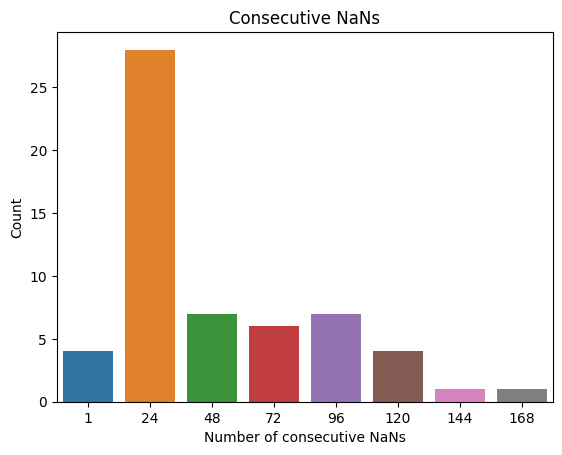

In [123]:
plot_consecutive_nans(data_reindexed, "Consumo")

Veo que en general, huecos (como filas de NaN´s consecutivos) se agurpan en bloques de 24. Dado los datos vienen en frecuencia horaria, 24 NaN´s seguidos corresponden a 1 día, y 168 a 7 días. 

Tenía intención de hacer una función que haga interpolación **SOLO** de los bloques de NaN´s cortos, como para no afectar demasiado la función objetivo.
Puede hacerse interpolación de los pocos huecos de 1 hora (solo afectaría a 4 huecos), y el siguiente treshold sería ya de interpolar 24 horas... interpolaré hasta los bloques de 24 horas.

In [124]:
# def interpolate_with_threshold(df, column, threshold):
#     # Create a mask of NaNs
#     mask = df[column].isna()

#     # Identify groups of consecutive NaNs
#     mask_diff = mask.diff().fillna(False)
#     groups = mask_diff.cumsum()[mask]

#     # Count the size of each group
#     group_counts = groups.map(groups.value_counts())

#     # Create a mask for groups that are less than or equal to the threshold
#     interpolate_mask = group_counts <= threshold

#     # Interpolate only where the mask is True
#     df[column] = df[column].mask(mask).interpolate().where(interpolate_mask, df[column])

#     # Count and print the number of interpolated and not interpolated values
#     interpolated_count = interpolate_mask.sum()
#     not_interpolated_count = mask.sum() - interpolated_count

#     print(f"Interpolated count: {interpolated_count}")
#     print(f"Not interpolated count: {not_interpolated_count}")

# interpolate_with_threshold(data_reindexed, 'Consumo',5)

In [125]:
def procesar_timeseries(df, column, max_consecutive_nans=24):
    """
    Procesa una serie temporal para contar y reemplazar NaNs consecutivos.

    Parameters:
    df (pd.DataFrame): DataFrame con la serie temporal.
    column (str): Nombre de la columna a analizar.
    max_consecutive_nans (int): Máximo número de NaNs consecutivos a reemplazar.

    Returns:
    pd.DataFrame: DataFrame con los NaNs procesados.
    """
    if column not in df.columns:
        raise KeyError(f"La columna '{column}' no está presente en el DataFrame.")
    
    sr = df[column].copy()  # Copiar la serie para evitar el SettingWithCopyWarning
    
    # Contar y agrupar NaNs consecutivos
    nans = sr.isna()
    consecutive_nans = []
    count = 0

    for nan in nans:
        if nan:
            count += 1
        elif count > 0:
            consecutive_nans.append(count)
            count = 0
    
    if count > 0:
        consecutive_nans.append(count)

    # Imprimir la cuenta inicial de NaNs consecutivos
    print("Conteo inicial de NaNs consecutivos:")
    count_series = pd.Series(consecutive_nans).value_counts().sort_index()
    print(count_series)

    # Reemplazar NaNs consecutivos de tamaño <= max_consecutive_nans con los valores de 7 días atrás
    for i in range(len(sr)):
        if pd.isna(sr[i]):
            nan_start = i
            nan_end = nan_start
            while nan_end < len(sr) and pd.isna(sr[nan_end]):
                nan_end += 1
            nan_count = nan_end - nan_start
            if nan_count <= max_consecutive_nans:
                for j in range(nan_count):
                    if nan_start - 7*24 + j >= 0:
                        sr[nan_start + j] = sr[nan_start - 7*24 + j]
            i = nan_end

    df[column] = sr

    # Contar los NaNs consecutivos nuevamente después del reemplazo
    nans = sr.isna()
    consecutive_nans = []
    count = 0

    for nan in nans:
        if nan:
            count += 1
        elif count > 0:
            consecutive_nans.append(count)
            count = 0
    
    if count > 0:
        consecutive_nans.append(count)

    # Imprimir la cuenta final de NaNs consecutivos
    print("\nConteo final de NaNs consecutivos:")
    count_series = pd.Series(consecutive_nans).value_counts().sort_index()
    print(count_series)

    return df

In [126]:
data_reindexed = procesar_timeseries(data_reindexed, "Consumo", 24)

Conteo inicial de NaNs consecutivos:
1       4
24     28
48      7
72      6
96      7
120     4
144     1
168     1
Name: count, dtype: int64

Conteo final de NaNs consecutivos:
24     13
48      7
72      6
96      5
120     3
144     1
Name: count, dtype: int64


24     13
48      7
72      6
96      5
120     3
144     1
Name: count, dtype: int64


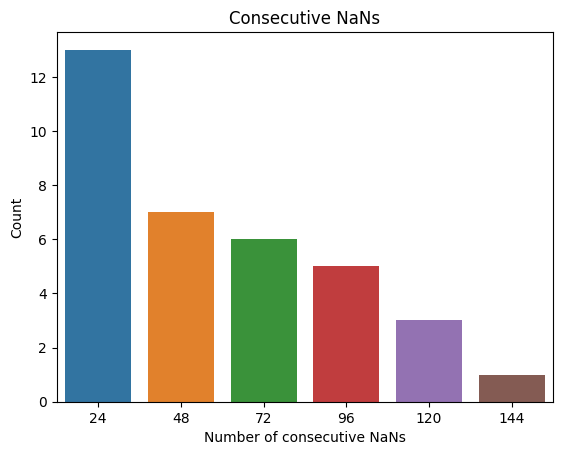

In [127]:
plot_consecutive_nans(data_reindexed, "Consumo")

In [128]:
grafico_zoom(data_reindexed["Date"], data_reindexed["Consumo"],
              "Consumo Eléctrico - Casal La Monserratina, de 2022 a 2024", "Consumo [kWh]")

# TODO modificar la fucnion para que guarde esta imagen. Abajo el código limpio, sin función, tampoco funciona. 
# 
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#     x=data_reindexed["Date"], 
#     y=data_reindexed["Consumo"], 
#     mode='lines', 
#     name='Line', 
#     connectgaps=False 
# ))
# fig.update_layout(
#     title="Consumo Eléctrico (con datos faltantes)",  
#     xaxis_title="Date",
#     yaxis_title="Consumo [kWh]", 
#     xaxis_tickangle=0, 
#     showlegend=False
# )

# # # Guardar la imagen en el archivo especificado
# fig.write_image("consumo con huecos_AUTO", format="png")

# fig.show() 

## Gaficas varias de la variable Consumo

### consumo resampleado a una semana

In [129]:
# Weekly Demand Plot
whole_df_1w = df.resample('1W').mean()

fig = go.Figure()
fig.add_trace(go.Scatter(x=whole_df_1w.index, y=whole_df_1w["Consumo"], mode='lines'))
fig.update_layout(
    title = "Consumo Eléctrico (Resample 1 semana) - Casal La Monserratina",
    xaxis_title = "Date",
    yaxis_title = "Demand (kWh)",
    width = 850,
    height = 400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

### consumo mes a mes

In [130]:
import calendar
from plotly.subplots import make_subplots
def plot_monthly_Consumo(df):
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    groups = df.groupby([df.index.year, df.index.month])
    num_plots = len(groups)
    fig = make_subplots(rows=6, cols=2, subplot_titles=[calendar.month_name[i] for i in range(1, 13)], horizontal_spacing=0.1, vertical_spacing=0.05)
    #colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    colors = ['blue', 'orange', 'green']

    for month in range(1, 13):
        row = (month - 1) // 2 + 1
        col = (month - 1) % 2 + 1
        monthly_data = df[df.index.month == month]
        unique_years = monthly_data.index.year.unique()
        for i, year in enumerate(unique_years):
            year_data = monthly_data[monthly_data.index.year == year]
            year_data = year_data.copy()
            year_data.index = year_data.index.map(lambda x: x.replace(year=2022))  # Normalizar el año para superponer curvas
            fig.add_trace(
                go.Scatter(x=year_data.index, y=year_data["Consumo"], mode='lines', name=f"{year}",
                           legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=False),
                row=row, col=col
            )
        if month == 1:
            for i, year in enumerate(unique_years):
                fig.add_trace(
                    go.Scatter(x=[None], y=[None], mode='lines', name=f"{year}",
                            legendgroup=f"{month}", line=dict(color=colors[i % len(colors)]), showlegend=True),
                    row=row, col=col
                )
                
        fig.update_xaxes(title_text="Date", row=row, col=col)
        fig.update_yaxes(title_text="Consumo (kWh)", row=row, col=col)
    fig.update_layout(
        title = {
            "text": "Consumo Mes a Mes",
            'x': 0.5,
            'xanchor': 'center'
        },
        xaxis_title="Date",
        yaxis_title="Consumo (kWh)",
        width=1200,
        height=2000,
        margin=dict(l=20, r=20, t=45, b=20)   
    )
    
  
    fig.show()

plot_monthly_Consumo(df)

## Slice Dataset

la idea es dejar fuera los huecos del final, ya que no aportan informacion y suman error a las métricas de predicción 

In [131]:
def slicer_grafico (df, x, y, fecha_cambio, title="", yaxis_title=""):
    
    df_x = df[x].copy()
    df_y = df[y].copy()
    
    # Convierte la fecha de cambio a un objeto datetime para comparación  
    fecha_cambio = pd.to_datetime(fecha_cambio)
    
    # Dividir los datos en dos partes
    df_x_1 = df_x[df_x <= fecha_cambio]
    df_y_1 = df_y[:len(df_x_1)]
    df_x_2 = df_x[df_x > fecha_cambio]
    df_y_2 = df_y[len(df_x_1):]
    
    fig = go.Figure()
    
    # Primer trazo (antes de la fecha de cambio)
    fig.add_trace(go.Scatter(
        x=df_x_1, 
        y=df_y_1, 
        mode='lines', 
        name='Parte del dataset que se utilizará', 
        connectgaps=False,
        line=dict(color='blue')  # Color azul
    ))
    
    # Segundo trazo (después de la fecha de cambio)
    fig.add_trace(go.Scatter(
        x=df_x_2, 
        y=df_y_2, 
        mode='lines', 
        name='Parte del dataset que se descarta', 
        connectgaps=False,
        line=dict(color='lightgrey')  # Color gris claro
    ))
    
    fig.update_layout(
            title=title,  
            xaxis_title="Date",
            yaxis_title=yaxis_title, 
            xaxis_tickangle=0, 
            legend=dict(
                x=0.74,  # Ajusta la posición horizontal de la leyenda (0 a 1)
                y=0.98,  # Ajusta la posición vertical de la leyenda (0 a 1)
                bgcolor='rgba(255, 255, 255, 0.5)',  # Fondo semitransparente blanco
                bordercolor='rgba(0, 0, 0, 0.5)',  # Borde semitransparente negro
                borderwidth=1  # Ancho del borde
            )
    )
    
    
    # Guardar la imagen en el archivo especificado
    # fig.write_image(file, format="png")
    
    fig.show()


In [132]:

slicer_grafico(
    data_reindexed,
    "Date", 
    "Consumo", 
    "2023-11-30 23:00:00",  # Fecha de cambio
    title="Consumo Eléctrico con Cambio de Color", 
    yaxis_title="Consumo [kWh]")

In [133]:
# Definir las fechas inicial y final - 'YYYY-MM-DD HH:MM:SS'.
# fecha_inicial = '2022-07-02 00:00:00' # fecha donde empieza la zona "limpia"
fecha_inicial = '2022-01-01 00:00:00' # inicio
fecha_final = '2023-11-30 23:00:00'

# Obtener el DataFrame recortado
df_sliced = dataframe_slicer(data_reindexed, fecha_inicial, fecha_final)

### Outliers del df_sliced

In [134]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1891. Sus limites son -4.0 y 12.0.



c:\Users\afernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



Text(0.5, 0, 'Consumo [kWh]')

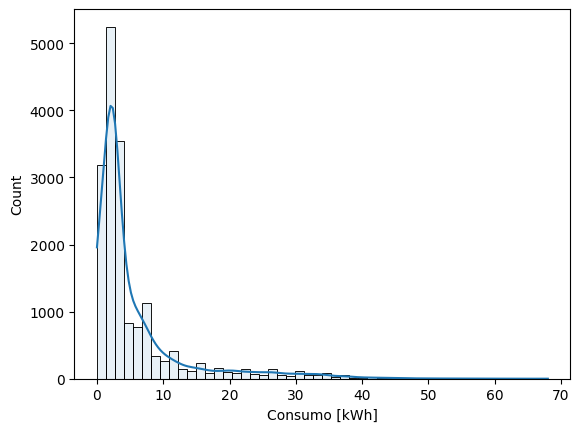

In [135]:
sns.histplot(data=df, x="Consumo", bins=50, alpha=0.1, kde=True)  # Histograma o KDE
plt.xlabel("Consumo [kWh]")

# TODO agregar otra version de este histograma

## Smoothing w/moving average

In [136]:
from statsmodels.robust.scale import mad

# Define the window size for the rolling mean
window_size = 24*1 # datos horarios, es decir, que el window_size esta en horas.

# Calculate the rolling mean
df_sliced['Consumo_smooth_mean'] = df_sliced['Consumo'].rolling(window=window_size).mean()
df_sliced['Consumo_smooth_std'] = df_sliced['Consumo'].rolling(window=window_size).std()

C:\Users\afernandez\AppData\Local\Temp\ipykernel_23572\1472781251.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\afernandez\AppData\Local\Temp\ipykernel_23572\1472781251.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
# Create traces for original and smoothed data
trace_original = go.Scatter(
    x=df_sliced["Date"], 
    y=df_sliced['Consumo'], 
    mode='lines', 
    name='Original', 
    line=dict(color='gray'), 
    opacity=0.5 
)
trace_smoothed_mean = go.Scatter(
    x=df_sliced["Date"], 
    y=df_sliced['Consumo_smooth_mean'], 
    mode='lines', 
    name='Smoothed Mean',
    line=dict(color='blue'),
    opacity= 0.8  
)
trace_smoothed_std = go.Scatter(
    x=df_sliced["Date"], 
    y=df_sliced['Consumo_smooth_std'], 
    mode='lines', 
    name='Smoothed std',
    line=dict(color='orange'), 
    opacity=0.8   
)

# Create layout
layout = go.Layout(
    title='Original vs Smoothed Data', 
    xaxis=dict(title='Date'), 
    yaxis=dict(title='Consumption [kWh]')
)

# Create figure
fig = go.Figure(data=[trace_original, trace_smoothed_mean, trace_smoothed_std], layout=layout)

# Show figure
fig.show()

In [138]:
df_sliced.describe()

Date       Consumo  Consumo_smooth_mean  \
count                16776  16536.000000         16375.000000   
mean   2022-12-16 11:30:00      5.640360             5.657153   
min    2022-01-01 00:00:00      0.000000             1.000000   
25%    2022-06-24 17:45:00      2.000000             2.541667   
50%    2022-12-16 11:30:00      3.000000             3.958333   
75%    2023-06-09 05:15:00      6.000000             6.791667   
max    2023-11-30 23:00:00     68.000000            35.875000   
std                    NaN      7.791734             4.796459   

       Consumo_smooth_std  
count        16375.000000  
mean             4.878668  
min              0.337832  
25%              1.983629  
50%              3.374027  
75%              6.775047  
max             25.294641  
std              3.992282

In [139]:
varianzaConsumo = round(df_sliced["Consumo"].var(),2)
print(f"Varianza del Consumo: {varianzaConsumo}")
varianzaConsumoSmoothMean = round(df_sliced["Consumo_smooth_mean"].var(),2)
print(f"Varianza del Consumo_smooth_mean: {varianzaConsumoSmoothMean}")
varianzaConsumoSmoothStd = round(df_sliced["Consumo_smooth_std"].var(),2)
print(f"Varianza del Consumo_smooth_std: {varianzaConsumoSmoothStd}")

Varianza del Consumo: 60.71
Varianza del Consumo_smooth_mean: 23.01
Varianza del Consumo_smooth_std: 15.94


In [140]:
getNumberOfOutliersPerColumn(df_sliced, df_sliced.columns.drop("Date"))

For Consumo Column, the Number of Outliers is 1891. Sus limites son -4.0 y 12.0.

For Consumo_smooth_mean Column, the Number of Outliers is 1310. Sus limites son -3.8333333333333335 y 13.166666666666668.

For Consumo_smooth_std Column, the Number of Outliers is 653. Sus limites son -5.203499563847207 y 13.96217566474066.



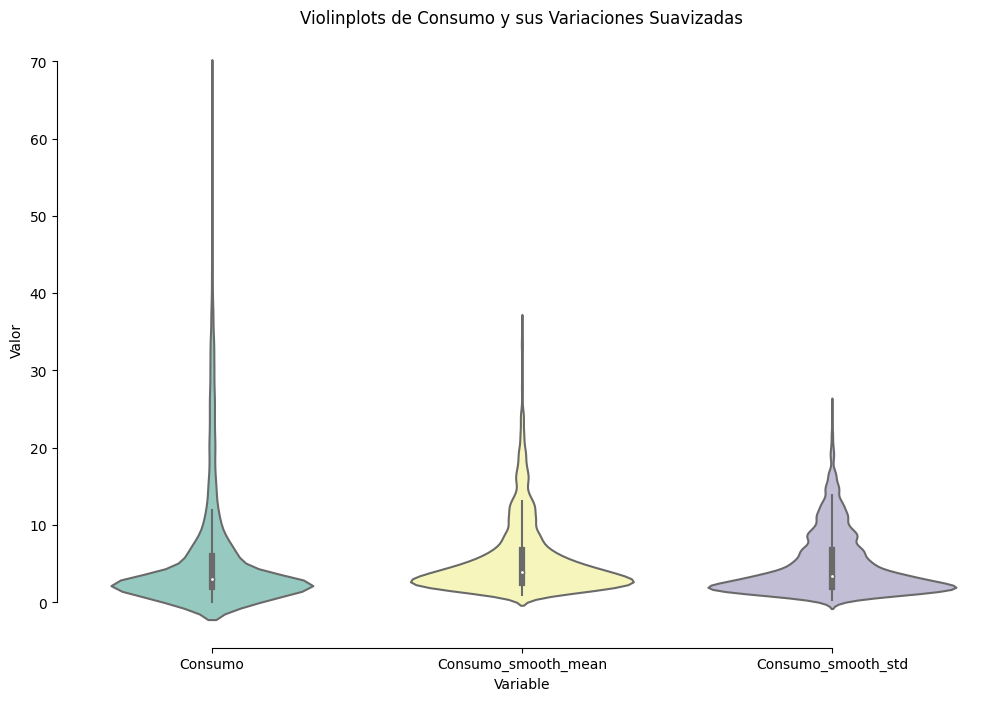

In [141]:
# Reorganizar el DataFrame en un formato largo
df_long = df_sliced.melt(id_vars=["Date"], value_vars=["Consumo", "Consumo_smooth_mean", "Consumo_smooth_std"],
                         var_name="Variable", value_name="Valor")

# Crear el gráfico de violín
plt.figure(figsize=(12, 8))
sns.violinplot(x="Variable", y="Valor", data=df_long, palette="Set3")

# Añadir un swarm plot para mostrar cada observación
#sns.swarmplot(x="Variable", y="Valor", data=df_long, color=".3", size=3)

# Ajustes adicionales de diseño
sns.despine(trim=True)
plt.xlabel("Variable")
plt.ylabel("Valor")
plt.title("Violinplots de Consumo y sus Variaciones Suavizadas")

plt.show()

No sé si se utilizará la versión de Consumo_smooth_mean, la dejo por si en el modelo de ML mejora en algo. 

# upsampling a 15 min

In [142]:
df_upsampled = df_sliced.copy()

In [143]:
df_upsampled.set_index("Date", inplace=True)

In [144]:
df_upsampled = df_upsampled.resample('15min').interpolate(method='time')
df_upsampled

Consumo  Consumo_smooth_mean  Consumo_smooth_std
Date                                                                 
2022-01-01 00:00:00      6.0                  NaN                 NaN
2022-01-01 00:15:00      6.0                  NaN                 NaN
2022-01-01 00:30:00      6.0                  NaN                 NaN
2022-01-01 00:45:00      6.0                  NaN                 NaN
2022-01-01 01:00:00      6.0                  NaN                 NaN
...                      ...                  ...                 ...
2023-11-30 22:00:00      2.0                3.125             2.09165
2023-11-30 22:15:00      2.0                3.125             2.09165
2023-11-30 22:30:00      2.0                3.125             2.09165
2023-11-30 22:45:00      2.0                3.125             2.09165
2023-11-30 23:00:00      2.0                3.125             2.09165

[67101 rows x 3 columns]

# Merge Consumo con PPV

In [145]:
# Load & prepatation of the DataFrame with the PV & weather data

nombre_archivo = "LaMonserratina_weather_&_PV.csv"
df_PV = pd.read_csv(os.path.join(ruta_data, nombre_archivo))

df_PV.rename(columns={"date": "Date"}, inplace=True)
df_PV.drop(columns=["Unnamed: 0"], inplace=True)

df_PV.sample(5)

Date  temperature_2m_C  relative_humidity_2m_%  \
107751  2024-01-28 09:45:00           11.0215               90.946152   
65072   2022-11-09 20:00:00           17.8715               59.691998   
26976   2021-10-09 00:00:00           17.3715               93.260101   
41771   2022-03-12 02:45:00           11.6590               92.196243   
58818   2022-09-05 16:30:00           27.1465               78.112427   

        dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
107751        9.584000                9.623165       1032.074951   
65072         9.921500               17.034241       1018.700012   
26976        16.271502               18.755610       1020.599976   
41771        10.434000               11.028649       1012.824951   
58818        22.446500               31.500716       1017.000000   

        surface_pressure_hPa  cloud_cover_%  cloud_cover_high_%  \
107751           1026.016602      85.750000               86.25   
65072            1012.860535      90.000010              100.00   
26976            1014.739380      37.800003                0.00   
41771            1006.893005     100.000000              100.00   
58818            1011.349548      11.250000                1.00   

        et0_fao_evapotranspiration_mm  ...  is_day  sunshine_duration_sec  \
107751                       0.079249  ...     1.0              2808.2805   
65072                        0.020895  ...     0.0                 0.0000   
26976                        0.000000  ...     0.0                 0.0000   
41771                        0.000000  ...     0.0                 0.0000   
58818                        0.229850  ...     1.0              3600.0000   

        shortwave_radiation_W/m2  direct_radiation_W/m2  \
107751                    186.25                  58.75   
65072                       0.00                   0.00   
26976                       0.00                   0.00   
41771                       0.00                   0.00   
58818                     332.50                 240.00   

        diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
107751                   127.5                     175.511703   
65072                      0.0                       0.000000   
26976                      0.0                       0.000000   
41771                      0.0                       0.000000   
58818                     92.5                     558.623413   

        global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
107751                         186.25                  444.966705   
65072                            0.00                    0.000000   
26976                            0.00                    0.000000   
41771                            0.00                    0.000000   
58818                          332.50                  562.917297   

        Temp_interna_Modulo_C    PV_kWh  
107751              26.196587  1.072044  
65072               25.305618  0.000000  
26976               25.079765  0.000000  
41771               22.499384  0.000000  
58818               42.179314  2.994154  

[5 rows x 24 columns]

In [146]:
# Preparación del df Consumo, para el merge
df_upsampled.rename(columns={"Consumo": "Consumo_kWh"}, inplace=True)
df_upsampled.rename(columns={"Consumo_smooth_mean": "Consumo_smooth_mean_kWh"}, inplace=True)
df_upsampled.rename(columns={"Consumo_smooth_std": "Consumo_smooth_std_kWh"}, inplace=True)

df_upsampled.reset_index(inplace=True)
df_upsampled['Date'] = pd.to_datetime(df_upsampled['Date'])
df_PV['Date'] = pd.to_datetime(df_PV['Date'])

### Merge

In [147]:
# Merge
df4 = df_upsampled.merge(df_PV, how="inner", on="Date")

Date  Consumo_kWh  Consumo_smooth_mean_kWh  \
1030  2022-01-11 17:30:00         36.0                19.625000   
52784 2023-07-04 20:00:00         29.0                10.958333   

       Consumo_smooth_std_kWh  temperature_2m_C  relative_humidity_2m_%  \
1030                15.923219           10.6465               91.370178   
52784               14.387432           22.9715               77.718391   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
1030         9.296499                9.432791       1023.949951   
52784       18.871500               25.949215       1016.299988   

       surface_pressure_hPa  ...  is_day  sunshine_duration_sec  \
1030            1017.931274  ...     0.0              154.58112   
52784           1010.574036  ...     0.0                0.00000   

       shortwave_radiation_W/m2  direct_radiation_W/m2  \
1030                        9.5                    5.0   
52784                       5.0                    1.0   

       diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
1030                      4.5                      56.655037   
52784                     4.0                      14.445930   

       global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
1030                             9.5                   32.117817   
52784                            5.0                   33.515011   

       Temp_interna_Modulo_C    PV_kWh  
1030               23.328438  0.353209  
52784              27.937338  0.086579  

[2 rows x 27 columns]

### calculo de la demanda=consumo+generacion (PV)

In [149]:
df4["Demanda_kWh"] = df4["Consumo_kWh"] + df4["PV_kWh"]
df4["Demanda_smooth_mean_kWh"] = df4["Consumo_smooth_mean_kWh"] + df4["PV_kWh"]
df4["Demanda_smooth_std_kWh"] = df4["Consumo_smooth_std_kWh"] + df4["PV_kWh"]

In [150]:
df4.sample(2)

Date  Consumo_kWh  Consumo_smooth_mean_kWh  \
48823 2023-05-24 13:45:00         0.00                 1.708333   
54737 2023-07-25 04:15:00         2.25                13.093750   

       Consumo_smooth_std_kWh  temperature_2m_C  relative_humidity_2m_%  \
48823                 1.45898         21.184002               69.092789   
54737                14.43204         21.734001               88.969955   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
48823          15.284               23.394054       1014.549988   
54737          19.834               24.763420       1009.924988   

       surface_pressure_hPa  ...  direct_radiation_W/m2  \
48823           1008.799438  ...                  508.0   
54737           1004.211304  ...                    0.0   

       diffuse_radiation_W/m2  direct_normal_irradiance_W/m2  \
48823                  235.75                     575.585388   
54737                    0.50                       0.000000   

       global_tilted_irradiance_W/m2  terrestrial_radiation_W/m2  \
48823                         743.75                 1175.490845   
54737                           0.50                    4.962733   

       Temp_interna_Modulo_C    PV_kWh  Demanda_kWh  Demanda_smooth_mean_kWh  \
48823              39.871143  3.147456     3.147456                 4.855789   
54737              27.050343  0.000000     2.250000                13.093750   

       Demanda_smooth_std_kWh  
48823                4.606436  
54737               14.432040  

[2 rows x 30 columns]

## add some extra exogenous variables columns

In [152]:
df4["Year"] = df4["Date"].dt.year
df4["Month"] = df4["Date"].dt.month
df4["Hour"] = df4["Date"].dt.hour
df4["DayOfWeek"] = df4["Date"].dt.day_of_week
df4["DayOfYear"] = df4["Date"].dt.day_of_year
df4["Day"] = df4["Date"].dt.day
#df4["Minute"] = df4["Date"].dt.minute

In [153]:
#Sine and Cosine Transformations
def cyclical_encoding(df, cycle_length_list, columns):
    for col, cycle_length in zip(columns, cycle_length_list):
        if df[col].min == 0:
            df[f"{col}_sin"] = np.sin((df[col] / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos((df[col] / cycle_length) * np.pi * 2).round(4)
        else:
            df[f"{col}_sin"] = np.sin(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
            df[f"{col}_cos"] = np.cos(((df[col] - 1) / cycle_length) * np.pi * 2).round(4)
    return df

In [155]:

#Add isWeekend Column based in DayOfTheWeek Value
df4["isWeekend"] = df4["DayOfWeek"].isin([5, 6])

cycle_lengths = [24, 7, 12, 365]
cols = ["Hour", "DayOfWeek", "Month", "DayOfYear"]

df4 = cyclical_encoding(df4, cycle_lengths, cols)

df4.sample(3)

Date  Consumo_kWh  Consumo_smooth_mean_kWh  \
3900  2022-02-10 15:00:00        20.00                17.125000   
1869  2022-01-20 11:15:00        42.25                20.541667   
56384 2023-08-11 08:00:00         6.00                 2.333333   

       Consumo_smooth_std_kWh  temperature_2m_C  relative_humidity_2m_%  \
3900                14.950098           12.7715               77.163712   
1869                18.373894           10.5715               65.535469   
56384                2.014441           28.1465               46.336735   

       dew_point_2m_C  apparent_temperature_C  pressure_msl_hPa  \
3900         8.871500               10.491604       1026.900024   
1869         4.371499                8.186924       1028.525024   
56384       16.121500               30.160885       1020.900024   

       surface_pressure_hPa  ...  Day  isWeekend  Hour_sin  Hour_cos  \
3900            1020.908752  ...   10      False   -0.5000   -0.8660   
1869            1022.477966  ...   20      False    0.5000   -0.8660   
56384           1015.258301  ...   11      False    0.9659   -0.2588   

       DayOfWeek_sin  DayOfWeek_cos  Month_sin  Month_cos  DayOfYear_sin  \
3900          0.9749        -0.2225        0.5      0.866         0.6354   
1869          0.9749        -0.2225        0.0      1.000         0.3213   
56384         0.4339        -0.9010       -0.5     -0.866        -0.6288   

       DayOfYear_cos  
3900          0.7722  
1869          0.9470  
56384        -0.7776  

[3 rows x 45 columns]

In [156]:
def generateHolidayVar(df):
    df["Reduced_Date"] = df["Date"].dt.date
    list_holidays = holidays.Spain(prov="CT", years=list(df["Year"].unique()))
    list_holidays_dates = np.array(list(list_holidays.keys()), dtype='datetime64')
    df["isHoliday"] = df["Reduced_Date"].isin(list_holidays_dates)
    df = df.drop('Reduced_Date', axis=1)
    return df

df4 = generateHolidayVar(df4)
display(df4[["Date", "isHoliday"]].sample(5))

Date  isHoliday
51574 2023-06-22 05:30:00      False
64332 2023-11-02 03:00:00      False
30811 2022-11-17 22:45:00      False
56413 2023-08-11 15:15:00      False
28371 2022-10-23 12:45:00      False

# Plots

## Consumo por mes

In [1]:
# fig, ax = plt.subplots(figsize=(20, 8))
# df4.boxplot(column='Consumo_kWh', by='Month', ax=ax)
# df4.groupby('Month')['Consumo_kWh'].mean().plot(style='o-', linewidth=.8, ax=ax)
# ax.set_ylabel('Consumo [kWh]')
# ax.set_title("Consumo promedio Mensual")
# fig.suptitle('')


# # Crear el gráfico de líneas
# fig, ax = plt.subplots(figsize=(20, 8))
# # Graficar cada variable
# ax.plot(df4.index, df4['Consumo_kWh'], label='Consumo [kWh]', linewidth=1, alpha=0.5) #, marker='o'
# ax.plot(df4.index, df4['Consumo_smooth_mean_kWh'], label='Consumo Smooth Mean [kWh]',  linestyle='--', linewidth=1) # marker='s',
# ax.plot(df4.index, df4['Consumo_smooth_std_kWh'], label='Consumo Smooth Std [kWh]', linestyle='-.', linewidth=1) # , marker='^'
# # Añadir etiquetas y título
# ax.set_ylabel('Consumo [kWh]')
# ax.set_title('Consumo Promedio Mensual')
# ax.legend()
# # Mostrar el gráfico
# plt.show()

# Configurar las posiciones de las barras
bar_width = 0.2
index = np.arange(len(df_grouped))

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar cada variable
bar1 = ax.bar(index, df_grouped['Consumo_kWh'], bar_width, label='Consumo [kWh]')
bar2 = ax.bar(index + bar_width, df_grouped['Consumo_smooth_mean_kWh'], bar_width, label='Consumo Smooth Mean [kWh]')
bar3 = ax.bar(index + 2 * bar_width, df_grouped['Consumo_smooth_std_kWh'], bar_width, label='Consumo Smooth Std [kWh]')

# Añadir etiquetas y título
ax.set_xlabel('Month')
ax.set_ylabel('Consumo [kWh]')
ax.set_title('Consumo Promedio Mensual')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df_grouped['Month'].astype(str))
ax.legend()

# Mostrar el gráfico
plt.show()

NameError: name 'df_mensual' is not defined

In [ ]:
# TODO guardar
# TODO cmabiar a linechart? u otro tipo de grafico que muestre algo mejor.

## Consumo total por día

Text(0.5, 0.98, '')

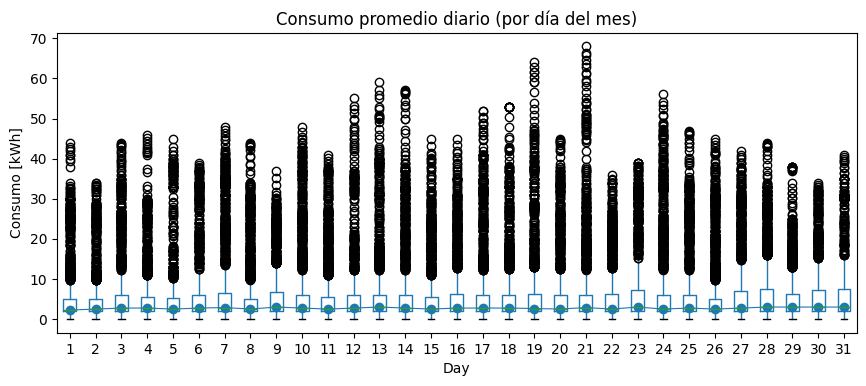

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Day', ax=ax)
df5.groupby('Day')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kWh]')
ax.set_title("Consumo promedio diario (por día del mes)")
fig.suptitle('')

In [ ]:
# TODO cmabiar a linechart? u otro tipo de grafico que muestre algo mejor. 

Text(0.5, 0.98, '')

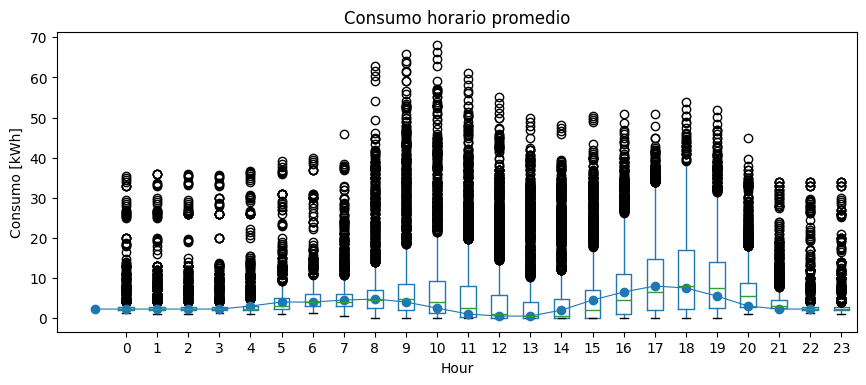

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='Consumo_kW', by='Hour', ax=ax)
df5.groupby('Hour')['Consumo_kW'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Consumo [kWh]')
ax.set_title("Consumo horario promedio")
fig.suptitle('')

In [ ]:
# TODO cambiar a linechart?.
# TODO guardar

## Demand per Day and Season

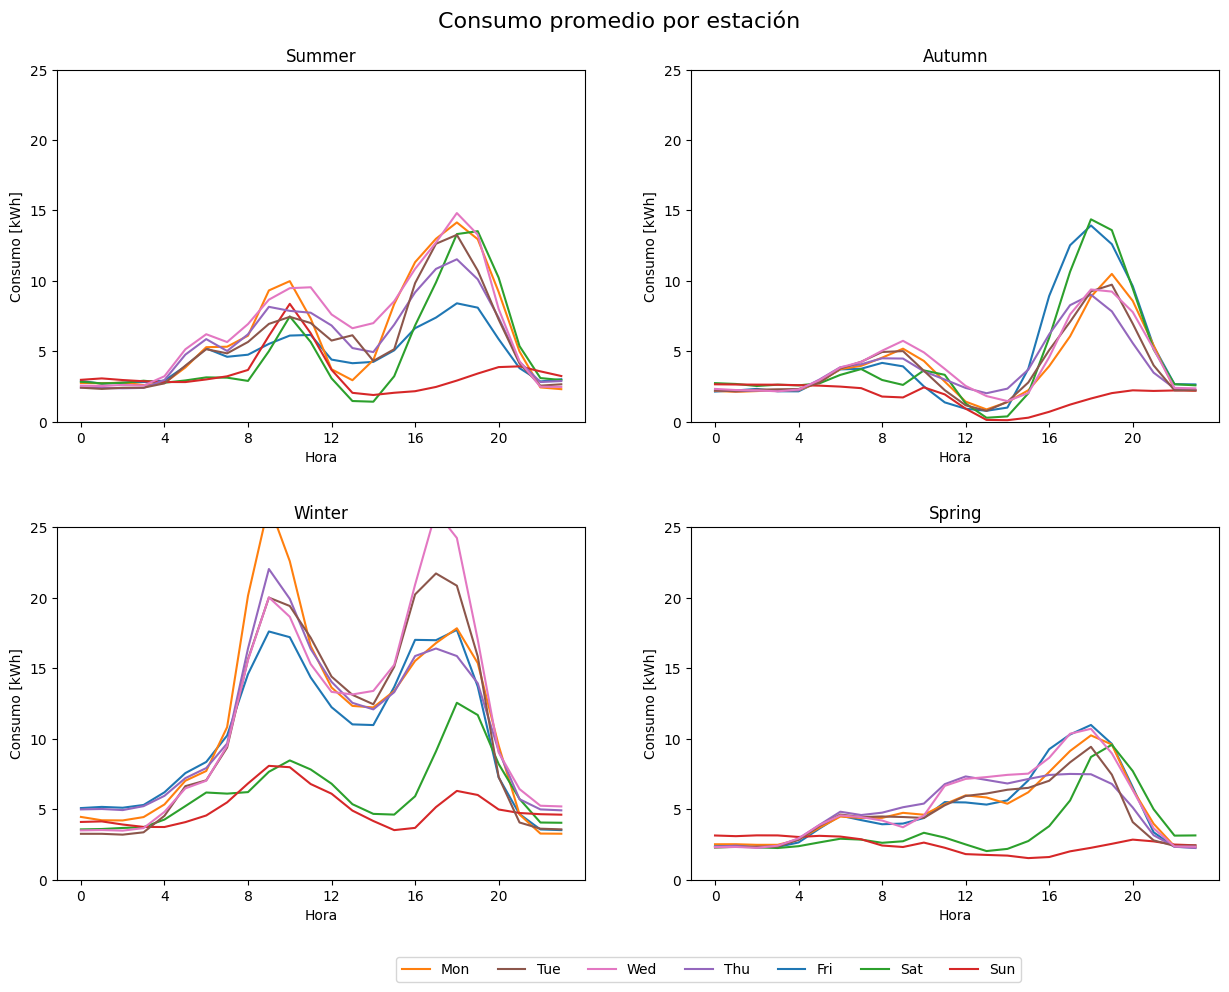

In [ ]:
days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df5["Day"] = df5["DayOfWeek"].map(days_mapping)
df5["Season"] = df5["Month"].apply(
    lambda x: (
        1 if x in [3, 4, 5] #Spring
        else 2 if x in [6, 7, 8] #Summer
        else 3 if x in [9, 10, 11] #Autumn
        else 0 #Winter
    )
)
fig, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.3, top=0.92)
fig.suptitle("Consumo promedio por estación", fontsize=16)

fig.set_figheight(10)
fig.set_figwidth(15)

ymin, ymax = 0, 25

#Season Summer
df5.loc[df5["Season"] == 2] \
    .groupby([df5.loc[df5["Season"] == 2]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 0], ylim=(ymin, ymax), title="Summer", legend=False
    )
df5.loc[df5["Season"] == 3] \
    .groupby([df5.loc[df5["Season"] == 3]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[0, 1], ylim=(ymin, ymax), title="Autumn", legend=False
    )
df5.loc[df5["Season"] == 0] \
    .groupby([df5.loc[df5["Season"] == 0]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 0], ylim=(ymin, ymax), title="Winter", legend=False
    )
df5.loc[df5["Season"] == 1] \
    .groupby([df5.loc[df5["Season"] == 1]["Hour"], 'Day'])["Consumo_kW"].mean().unstack().plot(
        ax=axes[1, 1], ylim=(ymin, ymax), title="Spring", legend=False
    )

for ax in axes.flat:
    ax.set(xlabel='Hora', ylabel='Consumo [kWh]')

for n in range(0, 2):
    axes[n, 0].set_xticks([0, 4, 8, 12, 16, 20])
    axes[n, 1].set_xticks([0, 4, 8, 12, 16, 20])
df5 = df5.drop("Day", axis=1)
# LEGEND
handles, labels = plt.gca().get_legend_handles_labels() # reorder Legend Labels
order = [1,5,6,4,0,2,3]      # specify order in Legend
axes[1,1].legend([handles[i] for i in order], [labels[i] for i in order], loc=1, ncol=7, 
                 bbox_to_anchor=(0.638,-0.2), frameon=True) # print and order LEGEND

## Temperature Distribution by Hour

Text(0.5, 0.98, '')

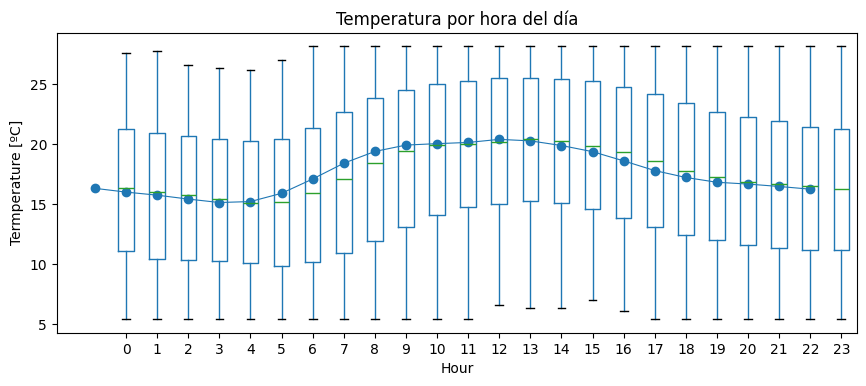

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
df5.boxplot(column='temperature_2m_C', by='Hour', ax=ax)
df5.groupby('Hour')['temperature_2m_C'].median().plot(style='o-', linewidth=.8, ax=ax)
ax.set_ylabel('Termperature [ºC]')
ax.set_title("Temperatura por hora del día")
fig.suptitle('')

## Relacion entre Demanda Energética y Temperatura. 

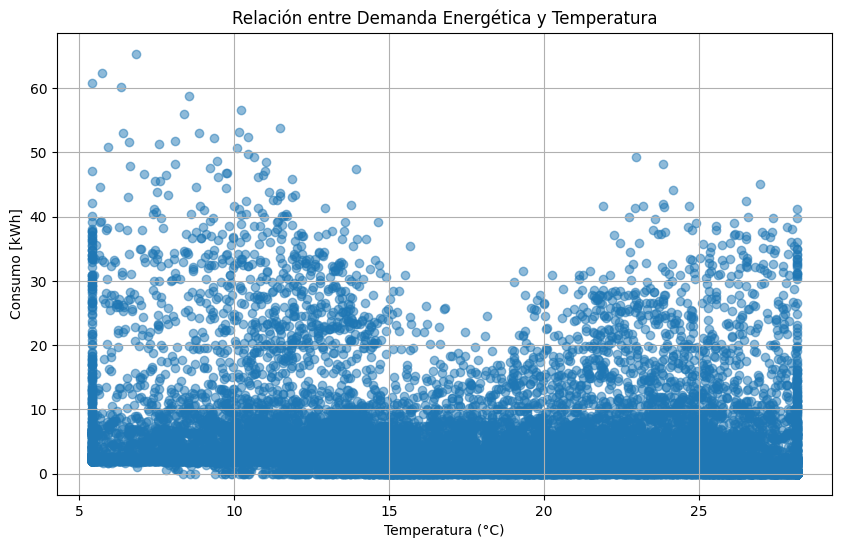

In [ ]:
def plot_temp_vs_demand(df):
    df = df.copy()
    df.set_index("Date", inplace=True)
    df_1h = df.resample('1h').mean()
    plt.figure(figsize=(10, 6))
    plt.scatter(df_1h['temperature_2m_C'], df_1h['Consumo_kW'], alpha=0.5)
    plt.title('Relación entre Demanda Energética y Temperatura')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Consumo [kWh]')
    plt.grid(True)
    plt.show()
plot_temp_vs_demand(df5)

# TODO rehacer este grafico, antes de aplicar la windsorizacion. 

Si hubiese buena correlacion entre demanda y temperatura, los puntos deberían formar una especie de "U", ya que cuanto mayor o menor sea la temperatura, mayor será el consumo energético para mejorar el confort. 

Por otro lado, los bordes rectos se deben a la windsorización de la temperatura en el preprocessing. 

## Irradiacion Solar (Mensual)

KeyError: 'Column not found: dhi_W/m2'

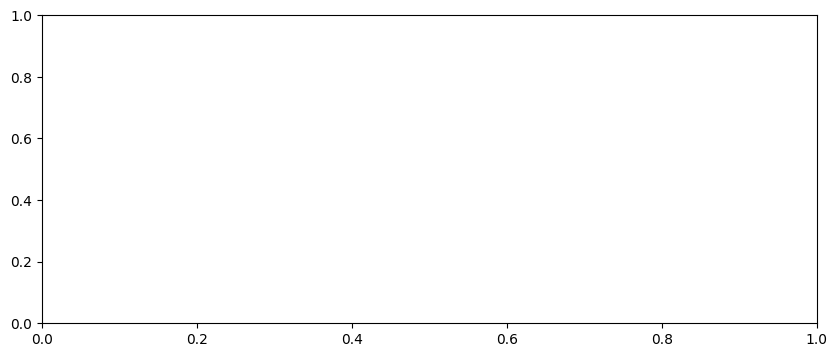

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Month', ax=ax)
df5.groupby('Month')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Month', ax=ax)
df5.groupby('Month')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar (Mensual)")
fig.suptitle('')

## Irradiacion Solar (Horaria)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

# df5.boxplot(column='dhi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dhi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='ghi_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['ghi_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

# df5.boxplot(column='dni_W/m2', by='Hour', ax=ax)
df5.groupby('Hour')['dni_W/m2'].median().plot(style='o-', linewidth=.8, ax=ax)

ax.legend(['dhi', 'ghi', 'dni'])

# dhi                      Irradiancia solar difusa en el plano horizontal    W/m2 [Clear Sky] 
# ghi                      Irradiancia solar global en el plano horizontal    W/m2 [Clear Sky] 
# dni                      Irradiancia solar directa normal                   W/m2 [Clear Sky] 

ax.set_ylabel('Irradiacion Solar [W/m^2]')
ax.set_title("Irradiacion Solar by Hour")
fig.suptitle('')

## AutoCorrelation Plots

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
#Gráfico de autocorrelación 1
df5.set_index("Date", inplace=True)
demand_df_1h = df5.resample('1h').mean()
fig, ax = plt.subplots(figsize=(13, 3))
plt.xlabel("Nº of lags")
plot_acf(demand_df_1h["Consumo_kW"], ax=ax, lags=24*7)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
#Gráfico de autocorrelación parcial
fig, ax = plt.subplots(figsize=(10, 3))
plt.xlabel("Nº of lags")
plot_pacf(demand_df_1h["Consumo_kW"], ax=ax, lags=24*7)
plt.title("Partial Autocorrelation Consumo_total [kW]")
plt.show()

## Correlation Matrix

In [ ]:
df5.columns

In [ ]:
# Calcula la matriz de correlación completa
correlation_matrix = df5.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(correlation_matrix)
mask[np.triu_indices_from(mask)] = True

# Imprime la matriz de correlación del cuadrante inferior
#plotting the heatmap for correlation
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, mask=mask, square=True, cmap='Greens', linewidths=2, linecolor='white');

In [ ]:
# VERSION LOLIPOP
# Ordenar el DataFrame de manera decreciente según la columna 'Consumo_kW'
sorted_correlation = correlation_matrix.sort_values(by='Consumo_kW', ascending=False)

# Crear un gráfico lollipop de la correlación respecto a la variable específica
plt.figure(figsize=(10, 6))
plt.stem(sorted_correlation.index, sorted_correlation['Consumo_kW'], basefmt=" ")
plt.title('Correlación con respecto al Target (Consumo_kW)')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=90)
plt.show()

# VERSION BARRAS
# # Ordenar el DataFrame de manera decreciente según la columna 'Consumo_kW'
# sorted_correlation = correlation_matrix.sort_values(by='Consumo_kW', ascending=False)

# # Crear un gráfico de barras de la correlación respecto a la variable específica
# plt.figure(figsize=(10, 6))
# sns.barplot(x=sorted_correlation.index, y=sorted_correlation['Consumo_kW'])
# plt.title('Correlación con respecto al Target (Consumo_kW)')
# plt.xlabel('Variables')
# plt.ylabel('Correlación')
# plt.xticks(rotation=90)
# plt.show()

## Time series decpomposition

In [ ]:
def decompose_time_series(df, column, freq):
    result = seasonal_decompose(df[column], model='additive', period=freq)
    df[f"{column}_trend"] = result.trend
    df[f"{column}_seasonal"] = result.seasonal
    df[f"{column}_residual"] = result.resid
    return df

In [ ]:
decomposed_df = decompose_time_series(df5, "Consumo_kW", 96)

decomposed_df.reset_index(inplace=True, drop=False)

decomposed_df.set_index('Date', inplace=True)

# Plot the decomposed time series
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
decomposed_df["Consumo_kW"].plot(ax=axes[0], title="Original")
decomposed_df["Consumo_kW_trend"].plot(ax=axes[1], title="Trend")
decomposed_df["Consumo_kW_seasonal"].plot(ax=axes[2], title="Seasonal")
decomposed_df["Consumo_kW_residual"].plot(ax=axes[3], title="Residual")
plt.tight_layout()

In [ ]:
df_seasonal = decomposed_df["Consumo_kW_seasonal"]

df_seasonal = df_seasonal.loc[(df_seasonal.index >= pd.to_datetime('2022-01-08 0:00', format='%Y-%d-%m %H:%M'))]
df_seasonal = df_seasonal.loc[(df_seasonal.index <= pd.to_datetime('2022-10-08 0:00', format='%Y-%d-%m %H:%M'))]

In [ ]:
grafico_zoom(df_seasonal.index, df_seasonal.values,
              "Patron Diario Consumo Eléctrico Casal La Monserratina", "residuo (kWh)", "seasonality")

# SAVE csv

In [ ]:
# Guardar el DataFrame como CSV
nombre_archivo = "LaMonserratina_CLEAN.csv"
ruta_completa = os.path.join(ruta_data, nombre_archivo)
df5.to_csv(ruta_completa, index=False)